# Sentiment Analysis for IMDB Reviews

### Initializing

In [1]:
import numpy as np
import mygrad as mg
try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

### Importing IMDB Dataset from files

In [3]:
import pickle
with open("./dat/word_list.pkl", mode="rb") as f:
    word_list = pickle.load(f)
    
import numpy as np
with np.load("./dat/imdb_review_data.npz") as archive:
    word_counts = archive["word_counts"] # Bag of words for each word
    ratings = archive["ratings"]
    stop_indices = archive["stop_indices"]

# Make sure to delete the stop words and update the ratings in the same cell that
# you load them. The reason for this is that deleting stop-word columns twice or
# "rounding" your ratings twice will mess up your data (think about why this is!)
# Thus including this code in this cell will guarantee that we load all of the
# data anew and then do this processing

# delete columns corresponding to stop words
word_counts = np.delete(word_counts, stop_indices, axis=1)

# coarsen the ratings
# 1-4 -> 0 (bad);  7-10 -> 1 (good)
ratings = (ratings >= 5).astype(int) 

***Exploring Dataset***

In [17]:
len(word_counts)

25000

In [18]:
word_counts[0]

array([4, 0, 0, ..., 0, 0, 0], dtype=int16)

In [22]:
for k in archive.files:
    print(k)

word_counts
ratings
stop_indices


In [4]:
len(word_list)

10543

In [52]:
print(word_list[1])

and


In [6]:
word_counts[0]

array([4, 0, 0, ..., 0, 0, 0], dtype=int16)

In [7]:
ratings[0]

1

### Computing the TF-IDF values

In [8]:
# here we compute the tf-idf descriptor for each review

# we need to specify "keepdims=True" so that the summed word counts
# can be broadcasting to each review
term_freq = word_counts / np.sum(word_counts, axis=1, keepdims=True)

idf = np.log10(len(word_counts) / np.sum(word_counts > 0, axis=0))
tfidf = term_freq * idf

In [9]:
# the data is pre-ordered so positive reviews start first, thus
# we need to shuffle the reviews (and perform the same shuffle on
# the ratings)
shuffle_inds = np.arange(tfidf.shape[0])
np.random.shuffle(shuffle_inds)
tfidf = tfidf[shuffle_inds]
ratings = ratings[shuffle_inds]

### Preparing & Normalizing the Dataset

In [51]:
tfidf[0]

array([ 5.56713384,  2.99512284, -0.06134963, ..., -0.06134963,
       -0.06134963, -0.06134963])

In [10]:
# split the data/labels into train and test sets
Ntrain = 20000
xtrain = tfidf[:Ntrain]
ytrain = ratings[:Ntrain]
xtest = tfidf[Ntrain:]
ytest = ratings[Ntrain:]

# 0-center and std-normalize the data
mean = xtrain.mean()
std = xtrain.std()
xtrain -= mean
xtrain /= std
xtest -= mean
xtest /= std

### Defining Model and Training

In [11]:
import mygrad as mg
from mynn.initializers import glorot_normal
from mynn.optimizers.sgd import SGD
from mynn.losses.cross_entropy import softmax_cross_entropy
from mynn.layers.dense import dense

class Model:
    def __init__(self, n):
        self.dense1 = dense(n, 2, weight_initializer=glorot_normal)
        
    def __call__(self, x):        
        return self.dense1(x)
    
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        return self.dense1.parameters
    
def accuracy(predictions, truth):
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

<IPython.core.display.Javascript object>


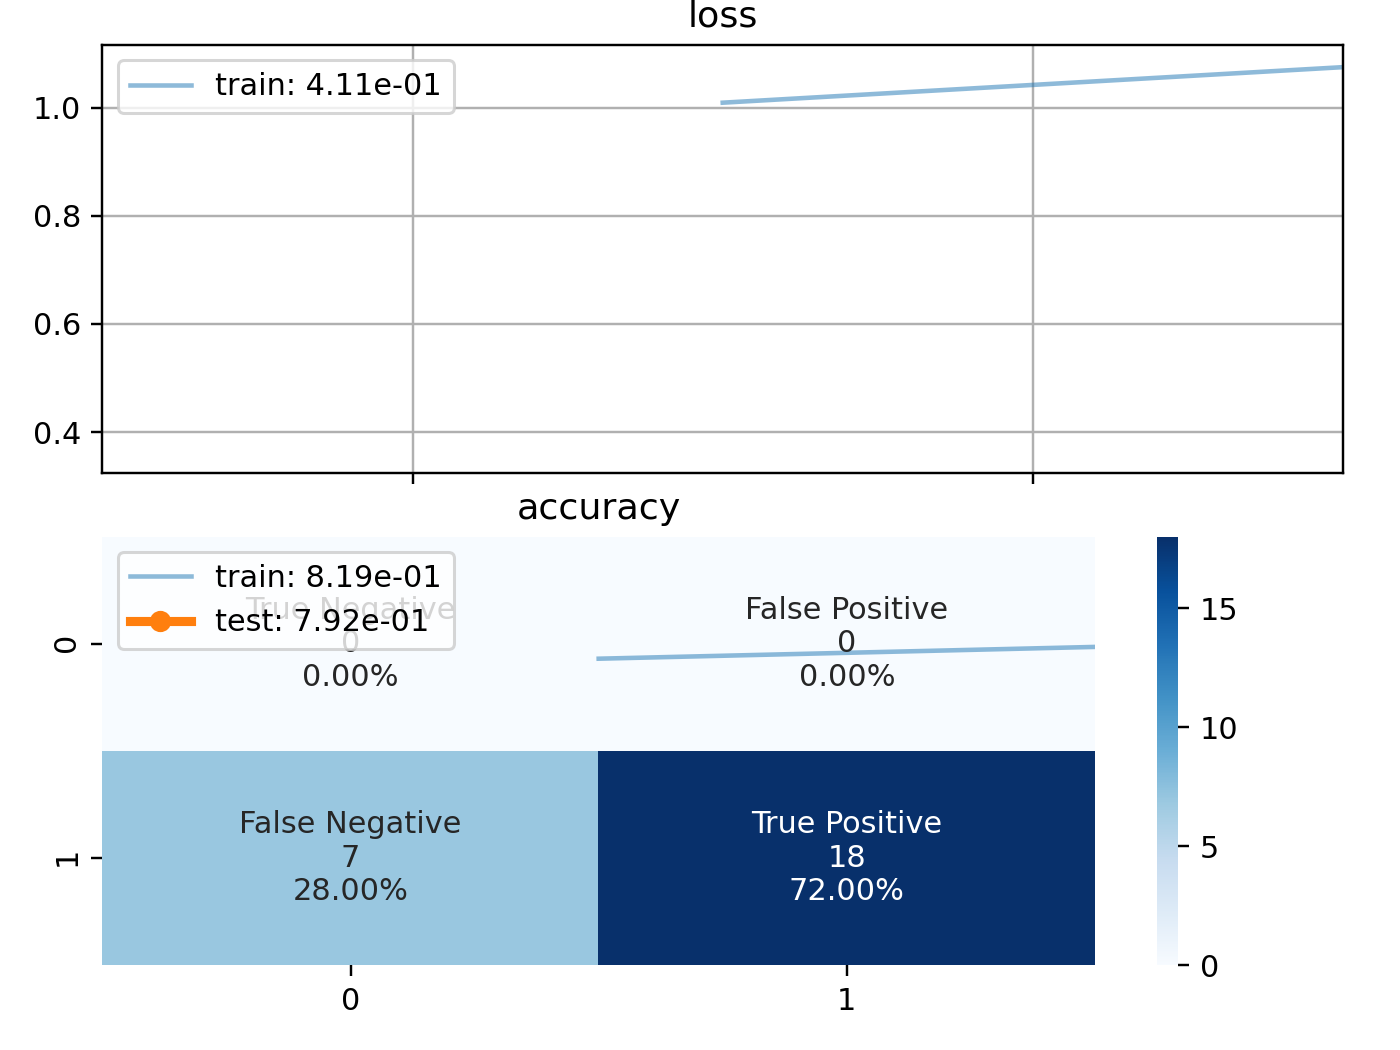

In [12]:
%matplotlib notebook
# import liveplot
# plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)
%matplotlib notebook
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [13]:
model = Model(xtrain.shape[1])
optim = SGD(model.parameters, learning_rate=1e-4) # originally: learning_rate=0.1

In [97]:
xtrain.shape

(20000, 10054)

In [98]:
xtrain[0].shape

(10054,)

In [93]:
ytrain[500]

0

In [16]:
batch_size = 1000

for epoch_cnt in range(250):
    idxs = np.arange(len(xtrain))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs) 
    
    for batch_cnt in range(0, len(xtrain)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = xtrain[batch_indices]  # random batch of our training data
        
        # compute the predictions for this batch by calling on model
        prediction = model(batch)

        # compute the true (a.k.a desired) values for this batch: 
        truth = ytrain[batch_indices]

        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss = softmax_cross_entropy(prediction, truth)

        # back-propagate through your computational graph through your loss
        loss.backward()

        # compute the accuracy between the prediction and the truth 
        acc = accuracy(prediction, truth)

        # execute gradient descent by calling step() of optim
        optim.step()
        
        # null your gradients (please!)
        loss.null_gradients()
        
        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    
    for batch_cnt in range(0, len(xtest)//batch_size):
        idxs = np.arange(len(xtest))
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = xtest[batch_indices] 
        
        # get your model's prediction on the test-batch
        prediction = model(batch)
        # get the truth values for that test-batch
        truth = ytest[batch_indices]
        # compute the test accuracy
        acc = accuracy(prediction, truth)
        
        # DO NOT back-prop or do gradient descent!
        
        # log the test-accuracy in liveplot for each-
        plotter.set_test_batch({ "accuracy" : acc},
                                 batch_size=batch_size)
    # this tells liveplot to plot the epoch-level train/test statistics :)
    #     plotter.plot_train_epoch()
    #     plotter.plot_test_epoch() 
    plotter.set_train_epoch()
    plotter.set_test_epoch()

C:\Users\gammi\.conda\envs\CogWorksW3\lib\site-packages\mygrad\tensor_base.py:1436: FutureWarning: `tensor.null_gradients()` is deprecated. Calling it will raise an error in future versions of MyGrad. A tensor will automatically have its gradient nulled if you use it in a new computational graph. Or, you can call `tensor.null_grad()` to null that individual tensor's gradient.
  warnings.warn(


# Testing on Lyrics

### Imports

In [25]:
import nltk 
from nltk.corpus import stopwords
import glob
nltk.download('stopwords')

def tokenize_without_stopwords(lyrics):
    tokenized = punc_regex.sub('', lyrics).lower().split()
    return tuple(word for word in tokenized if not word in stopwords.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gammi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
import re, string

punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))

## Importing Lyrics

### Positive Chorus

In [28]:
path = 'Positive Chorus/*.txt'
files = glob.glob(path, recursive=True)

all_test_songs = dict()

for file in files:
    f = open(file, "r")
    chorus = f.read().replace("\n", " ")
    song_title = file[:-4].replace("Positive Chorus\\", "")
    tokenized_chorus = tokenize_without_stopwords(chorus)
    
    all_test_songs[song_title] = tokenized_chorus
    
    f.close()

In [29]:
positive_chorus = all_test_songs

In [30]:
positive_chorus.keys()

dict_keys(['22', 'all_of_me', 'a_thousand_years', 'beautiful_day', 'best_day_of_my_life', 'cold_water', 'diamonds', 'dont_give_up_on_me', 'fight_song', 'firework', 'hall_of_fame', 'happy', 'high_hopes', 'holiday', 'just_the_way_you_are', 'party_in_the_usa', 'perfect', 'scars_to_your_beautiful', 'stronger', 'this_is_me', 'titanium', 'walking_on_sunshine', 'we_are_the_champions', 'what_a_wonderful_world', 'what_makes_you_beautiful'])

### Negative Chorus

In [31]:
path = 'Negative Chorus/*.txt'
files = glob.glob(path, recursive=True)

all_test_songs = dict()

for file in files:
    f = open(file, "r")
    chorus = f.read().replace("\n", " ")
    song_title = file[:-4].replace("Negative Chorus\\", "")
    tokenized_chorus = tokenize_without_stopwords(chorus)
    
    all_test_songs[song_title] = tokenized_chorus
    
    f.close()

In [32]:
negative_chorus = all_test_songs

In [33]:
negative_chorus.keys()

dict_keys(['boulevard_of_broken_dreams', 'fireflies', 'good_4_u', 'hold_on', 'how_to_save_a_life', 'impossible', 'leave_before_you_love_me', 'let_her_go', 'let_me_down_slowly', 'lose_somebody', 'love_story', 'love_yourself', 'sad_song', 'say_something', 'silence', 'someone_like_you', 'someone_you_loved', 'stitches', 'supermarket_flowers', 'too_good_at_goodbyes', 'train_wreck', 'viva_la_vida', 'waving_through_a_window', 'we_dont_talk_anymore', 'you_broke_me_first'])

### Positive Song Lyrics

In [34]:
path = 'Positive Song Lyrics/*.txt'
files = glob.glob(path, recursive=True)

all_test_songs = dict()

for file in files:
    f = open(file, "r")
    chorus = f.read().replace("\n", " ")
    song_title = file[:-4].replace("Positive Song Lyrics\\", "")
    tokenized_chorus = tokenize_without_stopwords(chorus)
    
    all_test_songs[song_title] = tokenized_chorus
    
    f.close()

In [35]:
positive_song_lyrics = all_test_songs

In [36]:
positive_song_lyrics.keys()

dict_keys(['22_full', 'all_of_me_full', 'a_thousand_years_full', 'beautiful_day_full', 'best_day_of_my_life_full', 'cold_water_full', 'diamonds_full', 'dont_give_up_on_me_full', 'fight_song_full', 'firework_full', 'hall_of_fame_full', 'happy_full', 'high_hopes_full', 'holiday_full', 'just_the_way_you_are_full', 'party_in_the_usa_full', 'perfect_full', 'scars_to_your_beautiful_full', 'stronger_full', 'this_is_me_full', 'titanium_full', 'walking_on_sunshine_full', 'we_are_the_champions_full', 'what_a_wonderful_world_full', 'what_makes_you_beautiful_full'])

### Negative Song Lyrics

In [37]:
path = 'Negative Song Lyrics/*.txt'
files = glob.glob(path, recursive=True)

all_test_songs = dict()

for file in files:
    f = open(file, "r")
    chorus = f.read().replace("\n", " ")
    song_title = file[:-4].replace("Negative Song Lyrics\\", "")
    tokenized_chorus = tokenize_without_stopwords(chorus)
    
    all_test_songs[song_title] = tokenized_chorus
    
    f.close()

In [38]:
negative_song_lyrics = all_test_songs

In [39]:
negative_song_lyrics.keys()

dict_keys(['boulevard_of_broken_dreams_full', 'fireflies_full', 'good_4_u_full', 'hold_on_full', 'how_to_save_a_life_full', 'impossible_full', 'leave_before_you_love_me_full', 'let_her_go_full', 'let_me_down_slowly_full', 'lose_somebody_full', 'love_story_full', 'love_yourself_full', 'sad_song_full', 'say_something_full', 'silence_full', 'someone_like_you_full', 'someone_you_loved_full', 'stitches_full', 'supermarket_flowers_full', 'too_good_at_goodbyes_full', 'train_wreck_full', 'viva_la_vida_full', 'waving_through_a_window_full', 'we_dont_talk_anymore_full', 'you_broke_me_first_full'])

In [54]:
positive_chorus["22"]

('dont',
 'know',
 'feeling',
 '22',
 'everything',
 'alright',
 'keep',
 'next',
 'dont',
 'know',
 'bet',
 'everything',
 'alright',
 'keep',
 'dancing',
 'like',
 '22',
 '22')

## Preprocessing

In [81]:
# Raw Data --> Word Frequencies
# Word Frequencies + Stop Word Removal
# Updated Word Frequencies --> TF-IDF Values
# TF-IDF Values + Normalization

In [115]:
# Turning word_list into vocab

from collections import defaultdict

def negative_one():
    return -1

vocab = defaultdict(negative_one)
for i in range(len(word_list)):
    vocab[word_list[i]] = i

In [116]:
# Using vocab to make word frequencies

# POSITIVE CHORUS

# Shape: # of Lyrics/Chorus in dict, # of words in vocab
word_frequencies_positive_chorus = np.zeros((len(positive_chorus.keys()),len(word_list)), dtype = np.int16) 
#print(word_frequencies_positive_chorus.shape)

row = 0
for name, chorus in positive_chorus.items():
    for word in chorus:
        word_index = vocab[word]
        if word_index != -1: # Word is found in vocabulary
            word_frequencies_positive_chorus[row, word_index] += 1
    row += 1


# NEGATIVE CHORUS

word_frequencies_negative_chorus = np.zeros((len(negative_chorus.keys()),len(word_list)), dtype = np.int16) 
#print(word_frequencies_positive_chorus.shape)

row = 0
for name, chorus in negative_chorus.items():
    for word in chorus:
        word_index = vocab[word]
        if word_index != -1: # Word is found in vocabulary
            word_frequencies_negative_chorus[row, word_index] += 1
    row += 1
    

# POSITIVE SONG LYRICS
    
word_frequencies_positive_song_lyrics = np.zeros((len(positive_song_lyrics.keys()),len(word_list)), dtype = np.int16) 
#print(word_frequencies_positive_chorus.shape)

row = 0
for name, chorus in positive_song_lyrics.items():
    for word in chorus:
        word_index = vocab[word]
        if word_index != -1: # Word is found in vocabulary
            word_frequencies_positive_song_lyrics[row, word_index] += 1
    row += 1
    
# NEGATIVE SONG LYRICS

word_frequencies_negative_song_lyrics = np.zeros((len(negative_song_lyrics.keys()),len(word_list)), dtype = np.int16) 
#print(word_frequencies_positive_chorus.shape)

row = 0
for name, chorus in negative_song_lyrics.items():
    for word in chorus:
        word_index = vocab[word]
        if word_index != -1: # Word is found in vocabulary
            word_frequencies_negative_song_lyrics[row, word_index] += 1
    row += 1    

In [117]:
# Removing Stop Words from Word Frequencies before calculating tf-idf values

# delete columns corresponding to stop words
word_frequencies_positive_chorus = np.delete(word_frequencies_positive_chorus, stop_indices, axis=1)
word_frequencies_negative_chorus = np.delete(word_frequencies_negative_chorus, stop_indices, axis=1)
word_frequencies_positive_song_lyrics = np.delete(word_frequencies_positive_song_lyrics, stop_indices, axis=1)
word_frequencies_negative_song_lyrics = np.delete(word_frequencies_negative_song_lyrics, stop_indices, axis=1)

In [118]:
# Calculating TF-IDF values

#Calculate this
term_freq_positive_chorus = word_frequencies_positive_chorus / np.sum(word_frequencies_positive_chorus, axis=1, keepdims=True)
term_freq_negative_chorus = word_frequencies_negative_chorus / np.sum(word_frequencies_negative_chorus, axis=1, keepdims=True)
term_freq_positive_song_lyrics = word_frequencies_positive_song_lyrics / np.sum(word_frequencies_positive_song_lyrics, axis=1, keepdims=True)
term_freq_negative_song_lyrics = word_frequencies_negative_song_lyrics / np.sum(word_frequencies_negative_song_lyrics, axis=1, keepdims=True)


# This don't need to recalculate
tfidf_positive_chorus = term_freq_positive_chorus * idf
tfidf_negative_chorus = term_freq_negative_chorus * idf
tfidf_positive_song_lyrics = term_freq_positive_song_lyrics * idf
tfidf_negative_song_lyrics = term_freq_negative_song_lyrics * idf

In [119]:
# Normalizing tfidf values using mean & std from original dataset

tfidf_positive_chorus -= mean
tfidf_positive_chorus /= std

tfidf_negative_chorus -= mean
tfidf_negative_chorus /= std

tfidf_positive_song_lyrics -= mean
tfidf_positive_song_lyrics /= std

tfidf_negative_song_lyrics -= mean
tfidf_negative_song_lyrics /= std

In [96]:
word_frequencies_positive_chorus.shape

(25, 10054)

In [88]:
model(word_frequencies_positive_chorus[0])

Tensor([[0.03343348, 0.02297146]], dtype=float32)

## Testing

### Choruses Confusion Matrix

In [128]:
choruses = np.vstack((tfidf_positive_chorus, tfidf_negative_chorus))
#print(choruses.shape)
prediction_choruses = model(choruses)
truth_choruses = np.hstack((np.ones((25,)), np.zeros((25,))))
#accuracy(prediction, truth)

[[15 10]
 [ 9 16]]


<IPython.core.display.Javascript object>


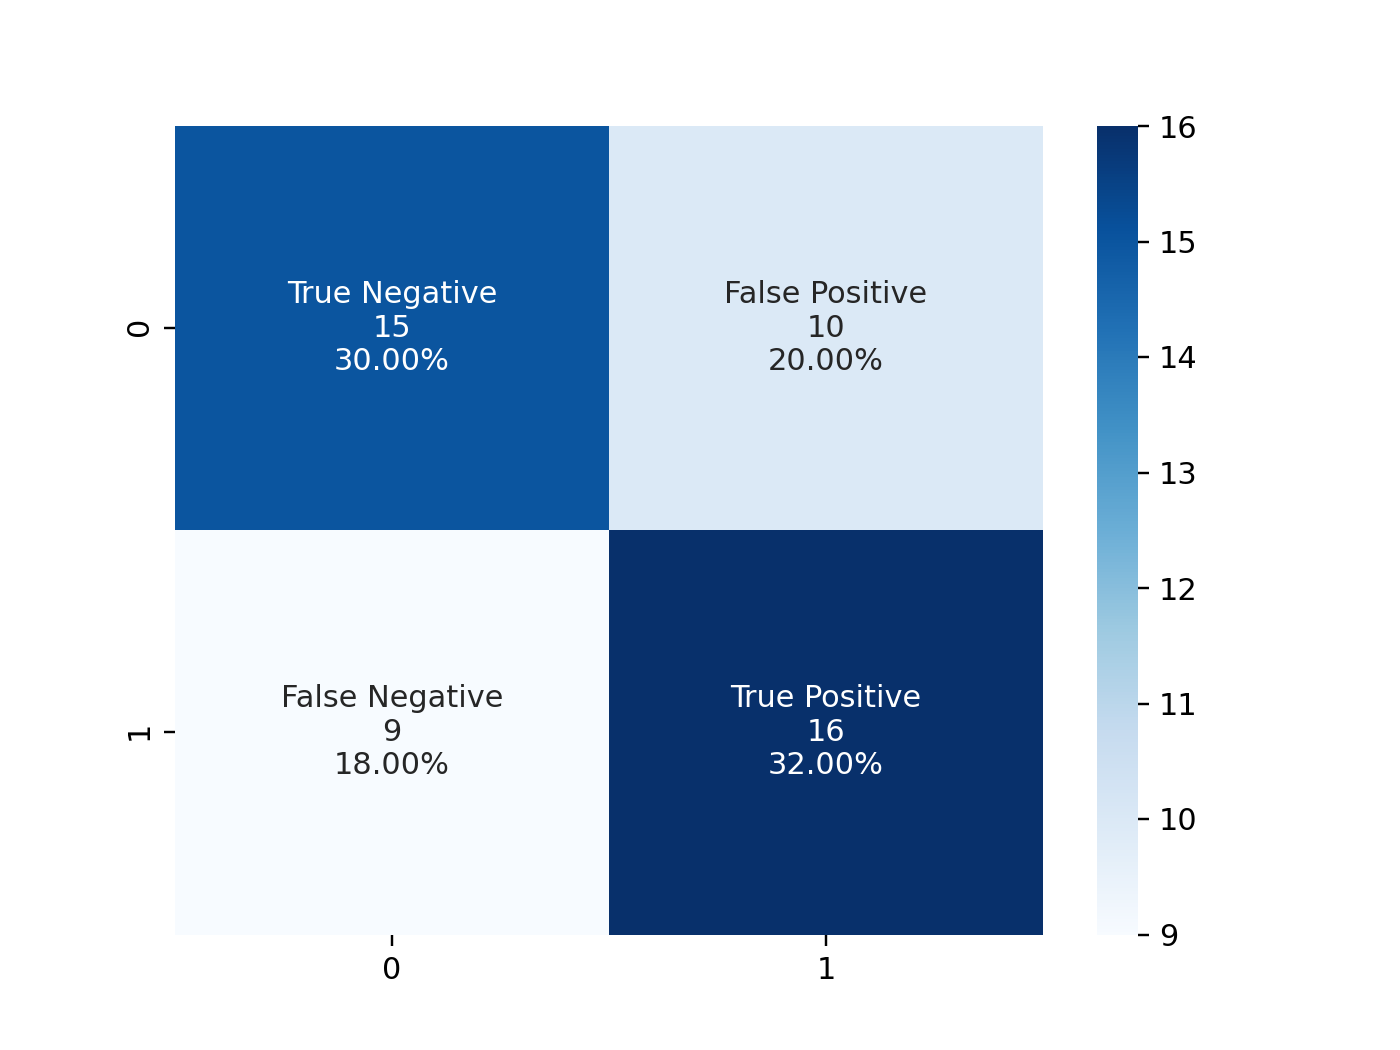

<AxesSubplot:>

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(truth_choruses, np.argmax(prediction_choruses, axis=1))
print(cf_matrix)

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

### Lyrics Confusion Matrix

In [130]:
lyrics = np.vstack((tfidf_positive_song_lyrics, tfidf_negative_song_lyrics))
prediction_lyrics = model(lyrics)
truth_lyrics = np.hstack((np.ones((25,)), np.zeros((25,))))

[[15 10]
 [10 15]]


<IPython.core.display.Javascript object>


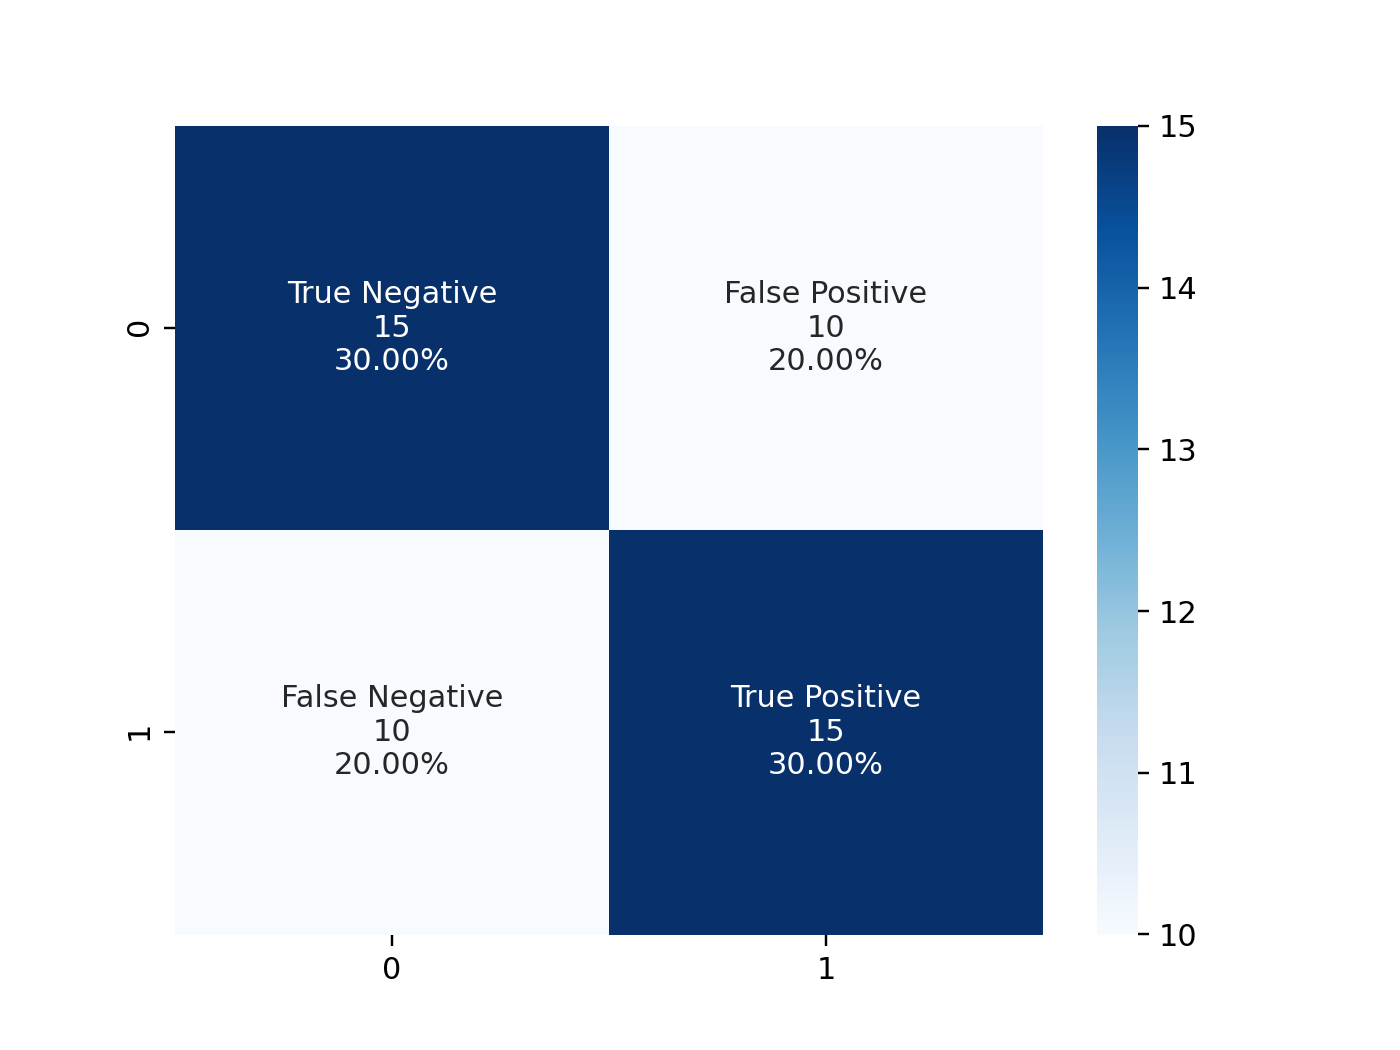

<AxesSubplot:>

In [131]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(truth_lyrics, np.argmax(prediction_lyrics, axis=1))
print(cf_matrix)

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [ ]:
y_pred = [0, 0, 0, 1, 1, 0, 1] # Model's prediction
test_truth = [1, 1, 1, 1, 1, 1]

In [ ]:
def accuracy(predictions, truth):
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

In [105]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
